# **Credit Risk Prediction ID/X Partners**

## Pemahaman Bisnis  
- Risiko kredit merujuk pada potensi kerugian akibat kegagalan debitur dalam memenuhi kewajiban pembayaran tepat waktu. Risiko ini menjadi faktor krusial dalam keputusan pemberian pinjaman oleh lembaga keuangan.
- Untuk meminimalkan risiko tersebut, perusahaan biasanya melakukan penilaian terhadap calon peminjam melalui mekanisme credit scoring dan credit rating sebelum menyetujui permohonan pinjaman.
- Dalam proyek ini, kita akan menganalisis data historis pinjaman dan menerapkan teknik machine learning untuk membangun model prediktif yang dapat mengestimasi risiko kredit dengan lebih akurat.

## Gathering Package and Data

In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

In [412]:
# Load dataset 
dataset_path = 'loan_data_2007_2014.csv'

In [414]:
# Read dataset
df = pd.read_csv(dataset_path)

C:\Users\azhar\AppData\Local\Temp\ipykernel_23080\1350862681.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


## Data Understanding

In [415]:
# Data Understanding
print("Dataset Info:\n")
df.info()
print(f"Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.\n")
print("Preview Data:\n", df.head())
print("Missing Values:\n", df.isnull().sum())
print("Descriptive Statistics:\n", df.describe())

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-nul

## Exploratory Data Analysis (EDA)

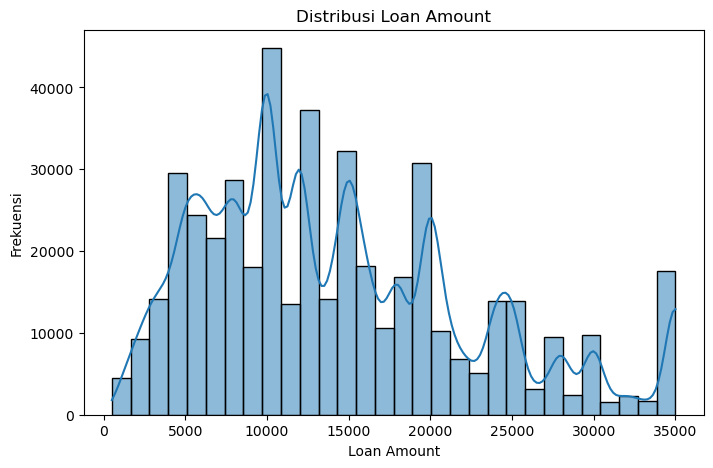

C:\Users\azhar\AppData\Local\Temp\ipykernel_23080\2106912856.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['loan_status'], order=df['loan_status'].value_counts().index, palette='viridis')


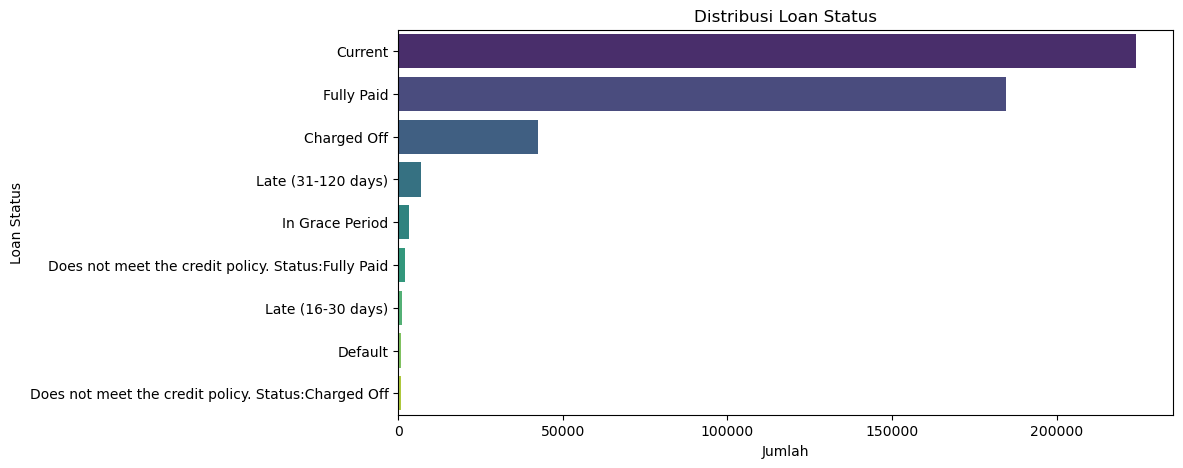

In [416]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_amnt'].dropna(), bins=30, kde=True)
plt.title('Distribusi Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frekuensi')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(y=df['loan_status'], order=df['loan_status'].value_counts().index, palette='viridis')
plt.title('Distribusi Loan Status')
plt.xlabel('Jumlah')
plt.ylabel('Loan Status')
plt.show()


In [417]:
# Mengatasi nilai yang tidak valid
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [422]:
# Handling missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
valid_numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]
if valid_numeric_cols:
    imputer = SimpleImputer(strategy='median')
    df[valid_numeric_cols] = imputer.fit_transform(df[valid_numeric_cols])

In [424]:
# Hapus kolom yang tidak relevan
drop_cols = ['url', 'desc', 'zip_code', 'member_id', 'id', 'emp_title', 'title', 'term']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [426]:
# Pastikan kolom target ada sebelum encoding
if 'loan_status' not in df.columns:
    raise KeyError("Kolom 'loan_status' tidak ditemukan dalam dataset.")

In [428]:
# Encoding variabel kategorikal
encoder = LabelEncoder()
df['loan_status'] = encoder.fit_transform(df['loan_status'].astype(str))

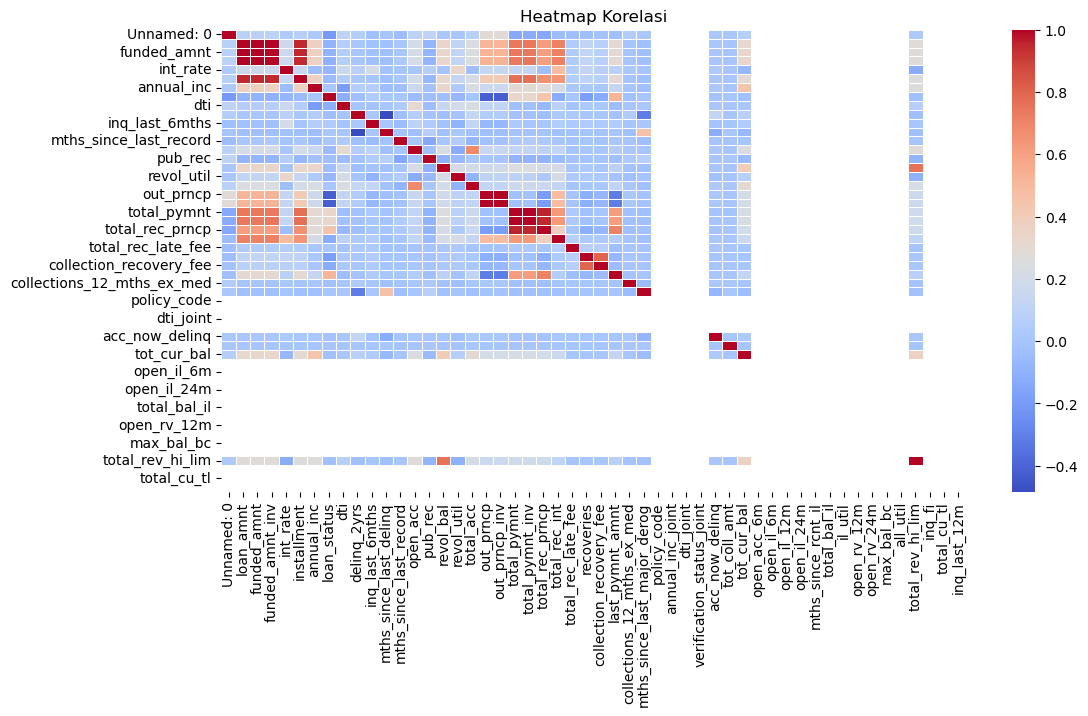

In [430]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

## Pemodelan, Evaluasi, & Menyimpan Model

In [432]:
# Split dataset
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [434]:
# Pastikan dataset tidak kosong setelah preprocessing
if X.shape[0] == 0:
    raise ValueError("Dataset kosong setelah preprocessing. Periksa langkah-langkah pembersihan data.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [436]:
# Hapus kolom yang hanya berisi NaN
X_train.dropna(axis=1, how='all', inplace=True)
X_test.dropna(axis=1, how='all', inplace=True)

In [444]:
# Encoding categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
if categorical_columns:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]),
                                   columns=encoder.get_feature_names_out(categorical_columns),
                                   index=X_train.index)
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]),
                                  columns=encoder.get_feature_names_out(categorical_columns),
                                  index=X_test.index)
    
    # Drop original categorical columns and merge encoded columns
    X_train.drop(columns=categorical_columns, inplace=True)
    X_test.drop(columns=categorical_columns, inplace=True)
    X_train = pd.concat([X_train, X_train_encoded], axis=1)
    X_test = pd.concat([X_test, X_test_encoded], axis=1)

In [448]:
# Pastikan tidak ada NaN sebelum scaling
if X_train[numeric_features].isna().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    X_train[numeric_features] = imputer.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = imputer.transform(X_test[numeric_features])

In [450]:
# Scaling
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [453]:
# Data Modelling
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [469]:
# Evaluasi model dengan multi-class ROC AUC
def evaluate_model(y_test, y_pred, y_pred_prob, model_name):
    print(f"Evaluation for {model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("----------------------------------------------------")


In [471]:
# Evaluasi model
evaluate_model(y_test, y_pred_logreg, logreg.predict_proba(X_test), "Logistic Regression")
evaluate_model(y_test, y_pred_rf, rf.predict_proba(X_test), "Random Forest")


Evaluation for Logistic Regression:
Accuracy: 0.9839583087596642
ROC AUC Score: 0.9730638604001945
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      8469
           1       0.98      1.00      0.99     44894
           2       0.83      0.80      0.82       173
           3       0.82      0.74      0.78       148
           4       0.92      0.94      0.93       377
           5       1.00      1.00      1.00     36906
           6       0.32      0.02      0.04       653
           7       0.14      0.01      0.02       237
           8       0.93      0.77      0.84      1400

    accuracy                           0.98     93257
   macro avg       0.77      0.70      0.71     93257
weighted avg       0.98      0.98      0.98     93257

Confusion Matrix:
 [[ 8333     0     0     0     0   136     0     0     0]
 [    0 44849     0     0     0     1    13     4    27]
 [    1     0   139     0     0     0  

C:\Users\azhar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azhar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azhar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Analisis Hasil Evaluasi Model
Dua model yang diuji adalah Logistic Regression dan Random Forest. Berikut adalah beberapa insight dari hasil evaluasi:

## 1. Performa Keseluruhan
- Akurasi:
  - Logistic Regression: 98.40%
  - Random Forest: 98.42%
  - Kedua model memiliki akurasi sangat tinggi, tetapi perlu analisis lebih lanjut karena akurasi tinggi bisa disebabkan oleh ketidakseimbangan data.

- ROC AUC Score:
  - Logistic Regression: 0.973
  - Random Forest: 0.968
  - Logistic Regression sedikit lebih baik dalam membedakan kelas dibanding Random Forest.

- Weighted Avg Precision, Recall, dan F1-score dari kedua model hampir sama. Namun, ada beberapa perbedaan signifikan dalam performa per kelas.

## 2. Kinerja Per Kelas
Dari Classification Report & Confusion Matrix, terlihat bahwa:

**a. Kelas Mayoritas (0, 1, 5) → Performa Sangat Baik**
- Kelas 1 (44894 sampel) dan Kelas 5 (36906 sampel) memiliki recall ~100%, artinya model mampu mendeteksi hampir semua instance dari kelas ini.
- Kelas 0 (8469 sampel) juga memiliki recall tinggi (>97%).
- Hal ini menunjukkan bahwa model sangat baik dalam memprediksi kelas mayoritas.

**b. Kelas Minoritas (6, 7, 8) → Performa Buruk**
- Kelas 6 (653 sampel) dan Kelas 7 (237 sampel) memiliki precision 0% pada Random Forest, artinya model tidak mampu memprediksi kelas ini dengan baik.
- Logistic Regression masih mampu memprediksi beberapa instance dari kelas ini, tetapi dengan recall sangat rendah (hanya 2% untuk kelas 6 dan 1% untuk kelas 7).
- Kelas 8 (1400 sampel) lebih baik dibanding kelas 6 & 7, tetapi recall tetap rendah.

🚨 **Insight Penting:**
- Model cenderung mengabaikan kelas minoritas dan lebih fokus ke kelas mayoritas.
- Random Forest bahkan tidak memprediksi kelas 6 & 7 sama sekali, yang menunjukkan bahwa model tidak cukup belajar dari data tersebut.
- Logistic Regression masih lebih baik dalam menangani kelas minoritas, tetapi tetap memiliki kinerja buruk.

## 3. Penyebab Performa Buruk pada Kelas Minoritas
Ketidakseimbangan data (class imbalance):
- Kelas 1 memiliki 44,894 sampel, sedangkan kelas 6 hanya 653 sampel. Model lebih fokus ke kelas mayoritas karena dominasi jumlah datanya.
- Kelas minoritas kurang representatif dalam training, sehingga sulit diprediksi dengan baik.

Random Forest tidak memiliki cukup informasi untuk memisahkan kelas minoritas, karena cenderung memaksimalkan keputusan berdasarkan kelas mayoritas.

In [484]:
import joblib

# Simpan model Logistic Regression
joblib.dump(logreg, "logistic_regression_model.pkl")

# Simpan model Random Forest
joblib.dump(rf, "random_forest_model.pkl")

print("Model berhasil disimpan!")


Model berhasil disimpan!
